## **Notebook #7**
## Autoencoder training and manifold visualization for the MNIST database.
## Partially based on [this material](https://www.kaggle.com/apapiu/manifold-learning-and-autoencoders).
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Arthur Felipe dos Santos Fernandes

### Loading the main libraries

In [1]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

### Reading the data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_images = x_train.reshape(x_train.shape[0], 28, 28)

In [5]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

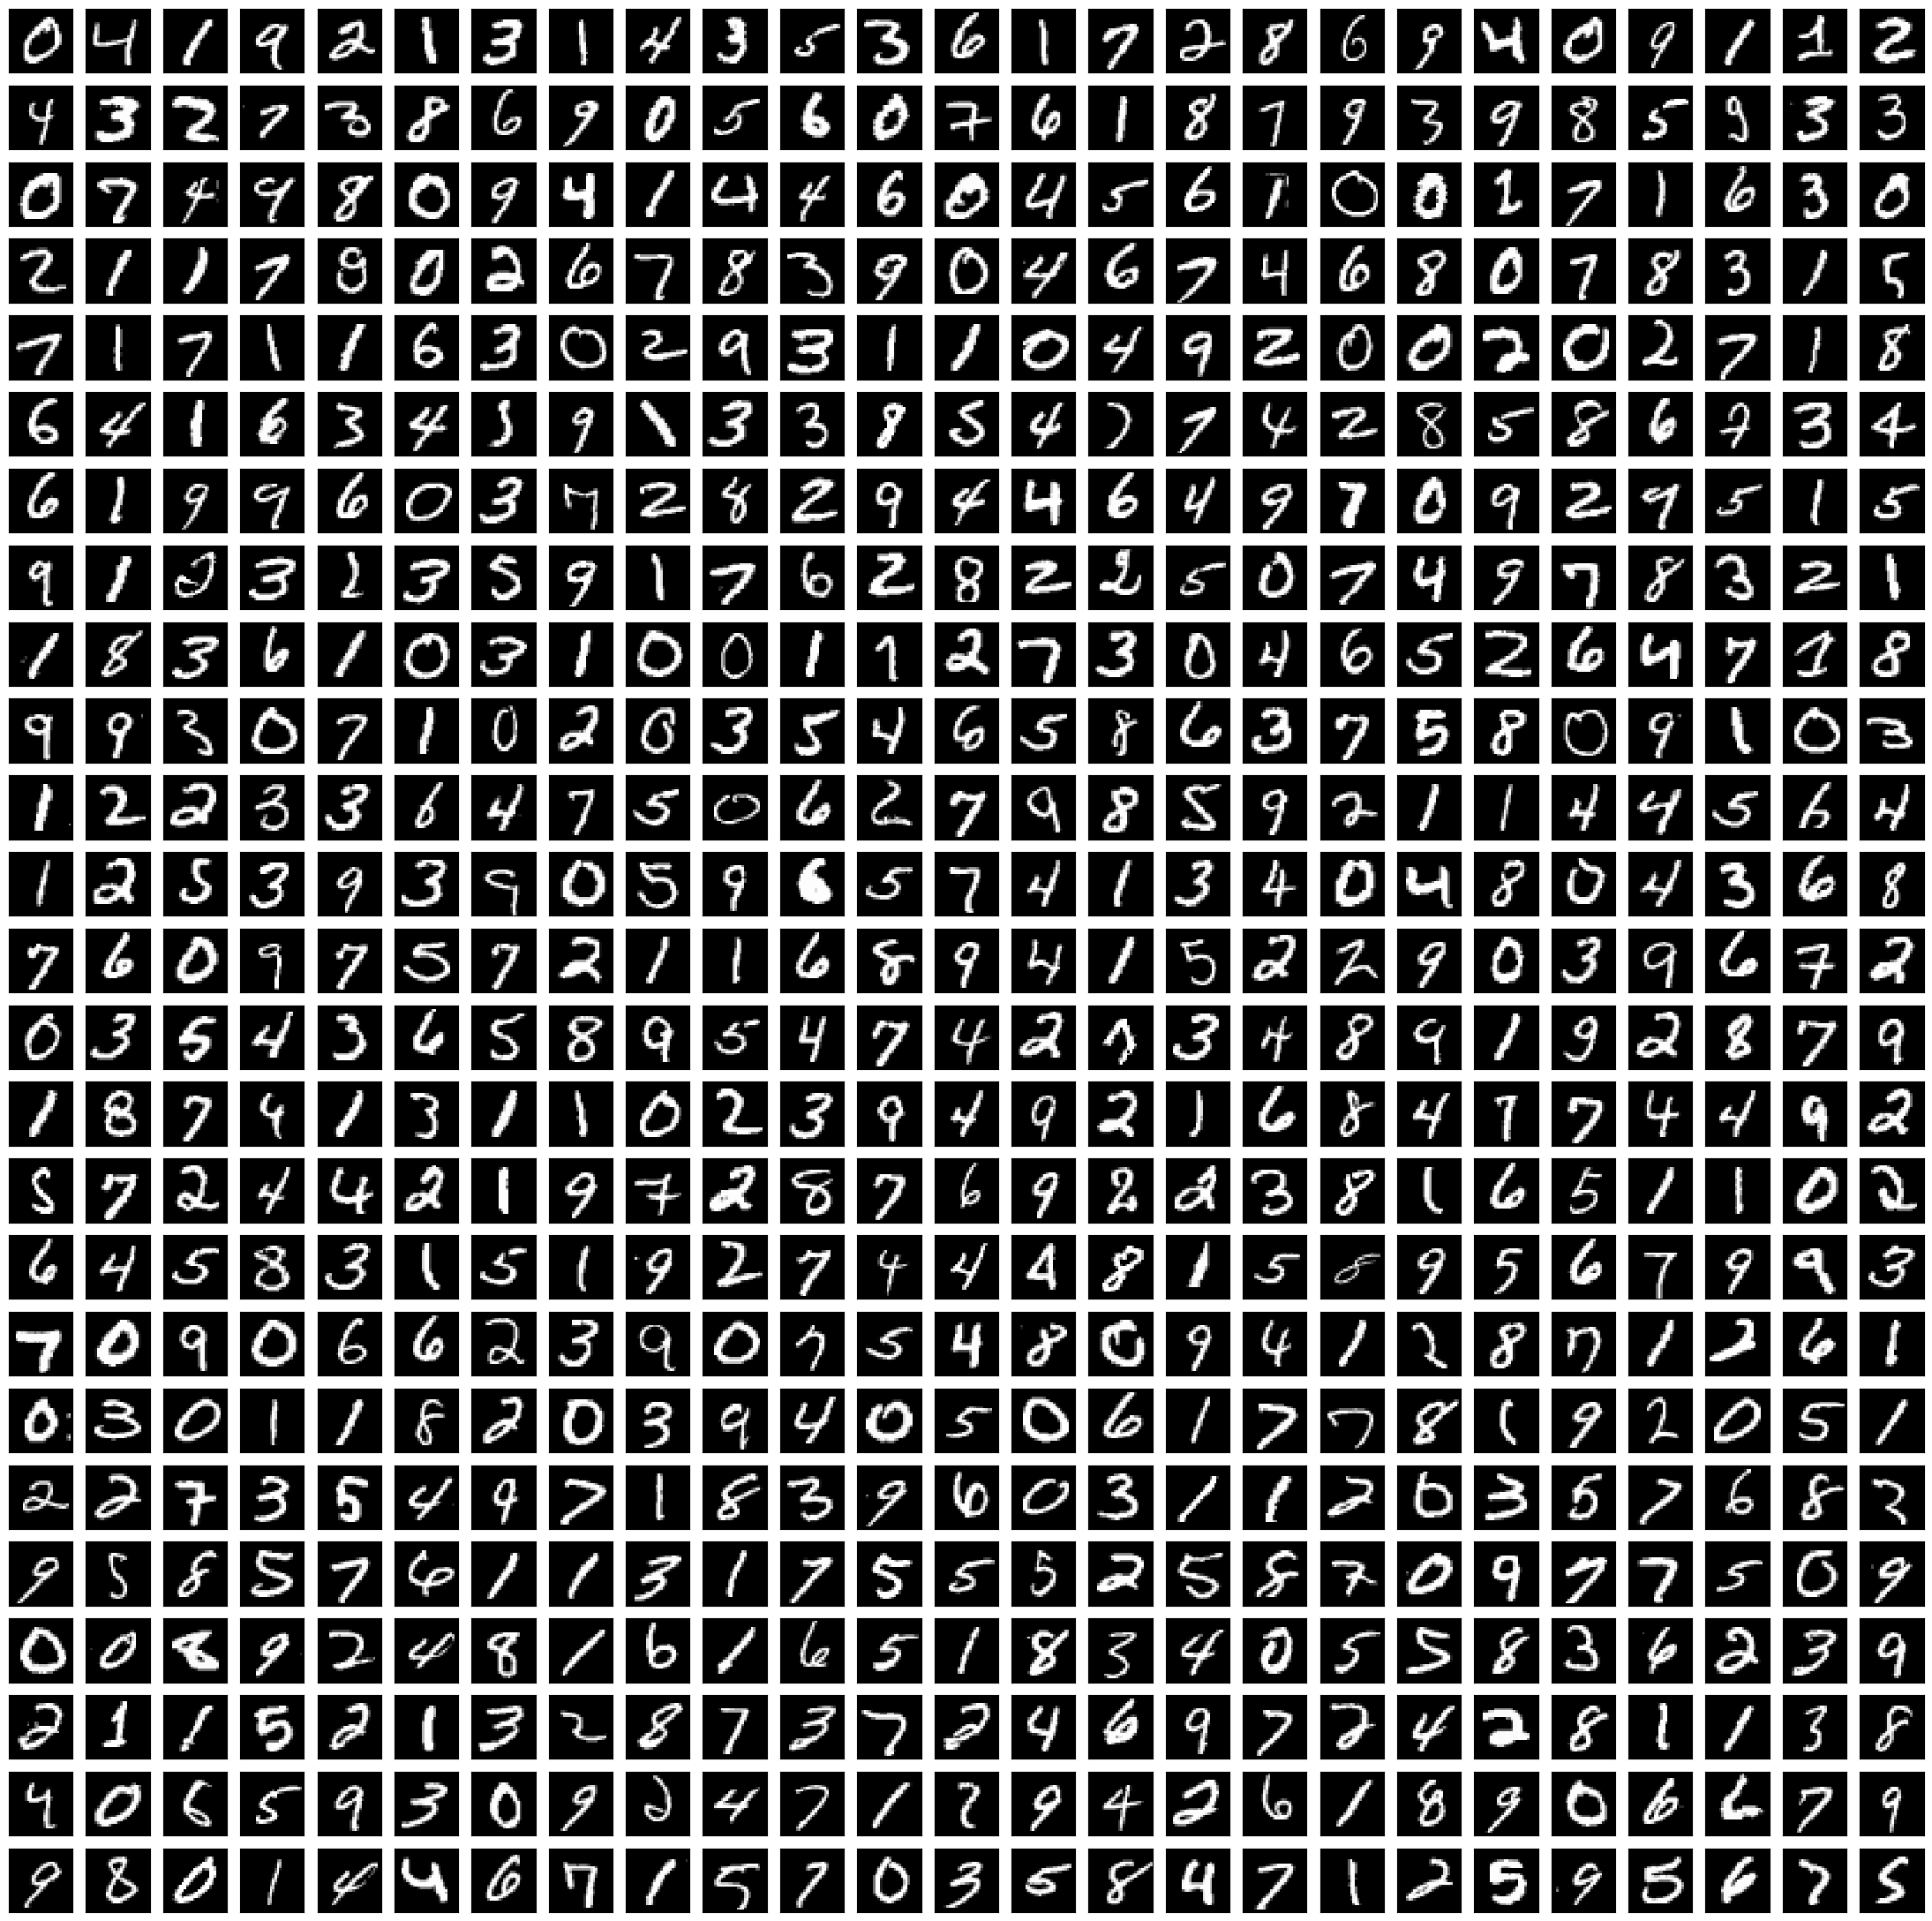

In [6]:
# Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### Proposal for the autoencoder architecture

In [7]:
input_img = Input(shape=(784,))

encoded = Dense(512, activation='tanh')(input_img)
encoded = Dense(128, activation='tanh')(encoded)
encoded = Dense(32, activation='tanh')(encoded)

encoded = Dense(2)(encoded) # Linear activation function at the bottleneck

decoded = Dense(32, activation='tanh')(encoded)
decoded = Dense(128, activation='tanh')(decoded)
decoded = Dense(512, activation='tanh')(decoded)

decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

In [8]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
 dense_4 (Dense)             (None, 32)                96        
                                                                 
 dense_5 (Dense)             (None, 128)               4224  

In [9]:
autoencoder.compile(optimizer = "adam", loss = "mse")
X = x_train.reshape(x_train.shape[0], 784)
history = autoencoder.fit(X, X, batch_size = 128, epochs = 50, verbose = 1)

Epoch 1/50
469/469 [==============================] - 8s 15ms/step - loss: 0.0621
Epoch 2/50
469/469 [==============================] - 8s 18ms/step - loss: 0.0485
Epoch 3/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0444
Epoch 4/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0425
Epoch 5/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0409
Epoch 6/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0397
Epoch 7/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0390
Epoch 8/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0385
Epoch 9/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0380
Epoch 10/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0375
Epoch 11/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0371
Epoch 12/50
469/469 [==============================] - 8s 17ms/step - loss: 0.0369
Epoch 13/50
4

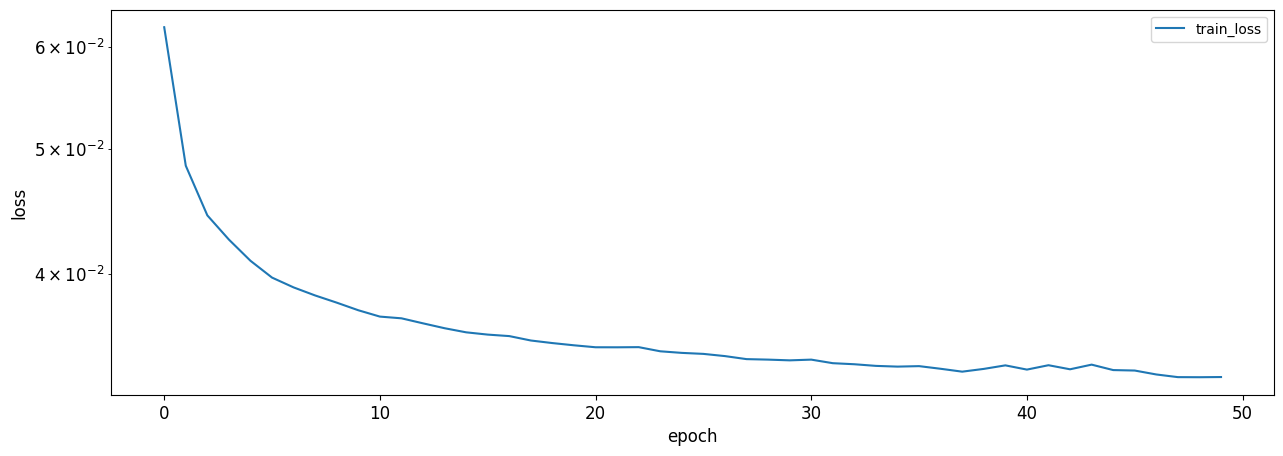

In [10]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

1/1 [==============================] - 0s 18ms/step


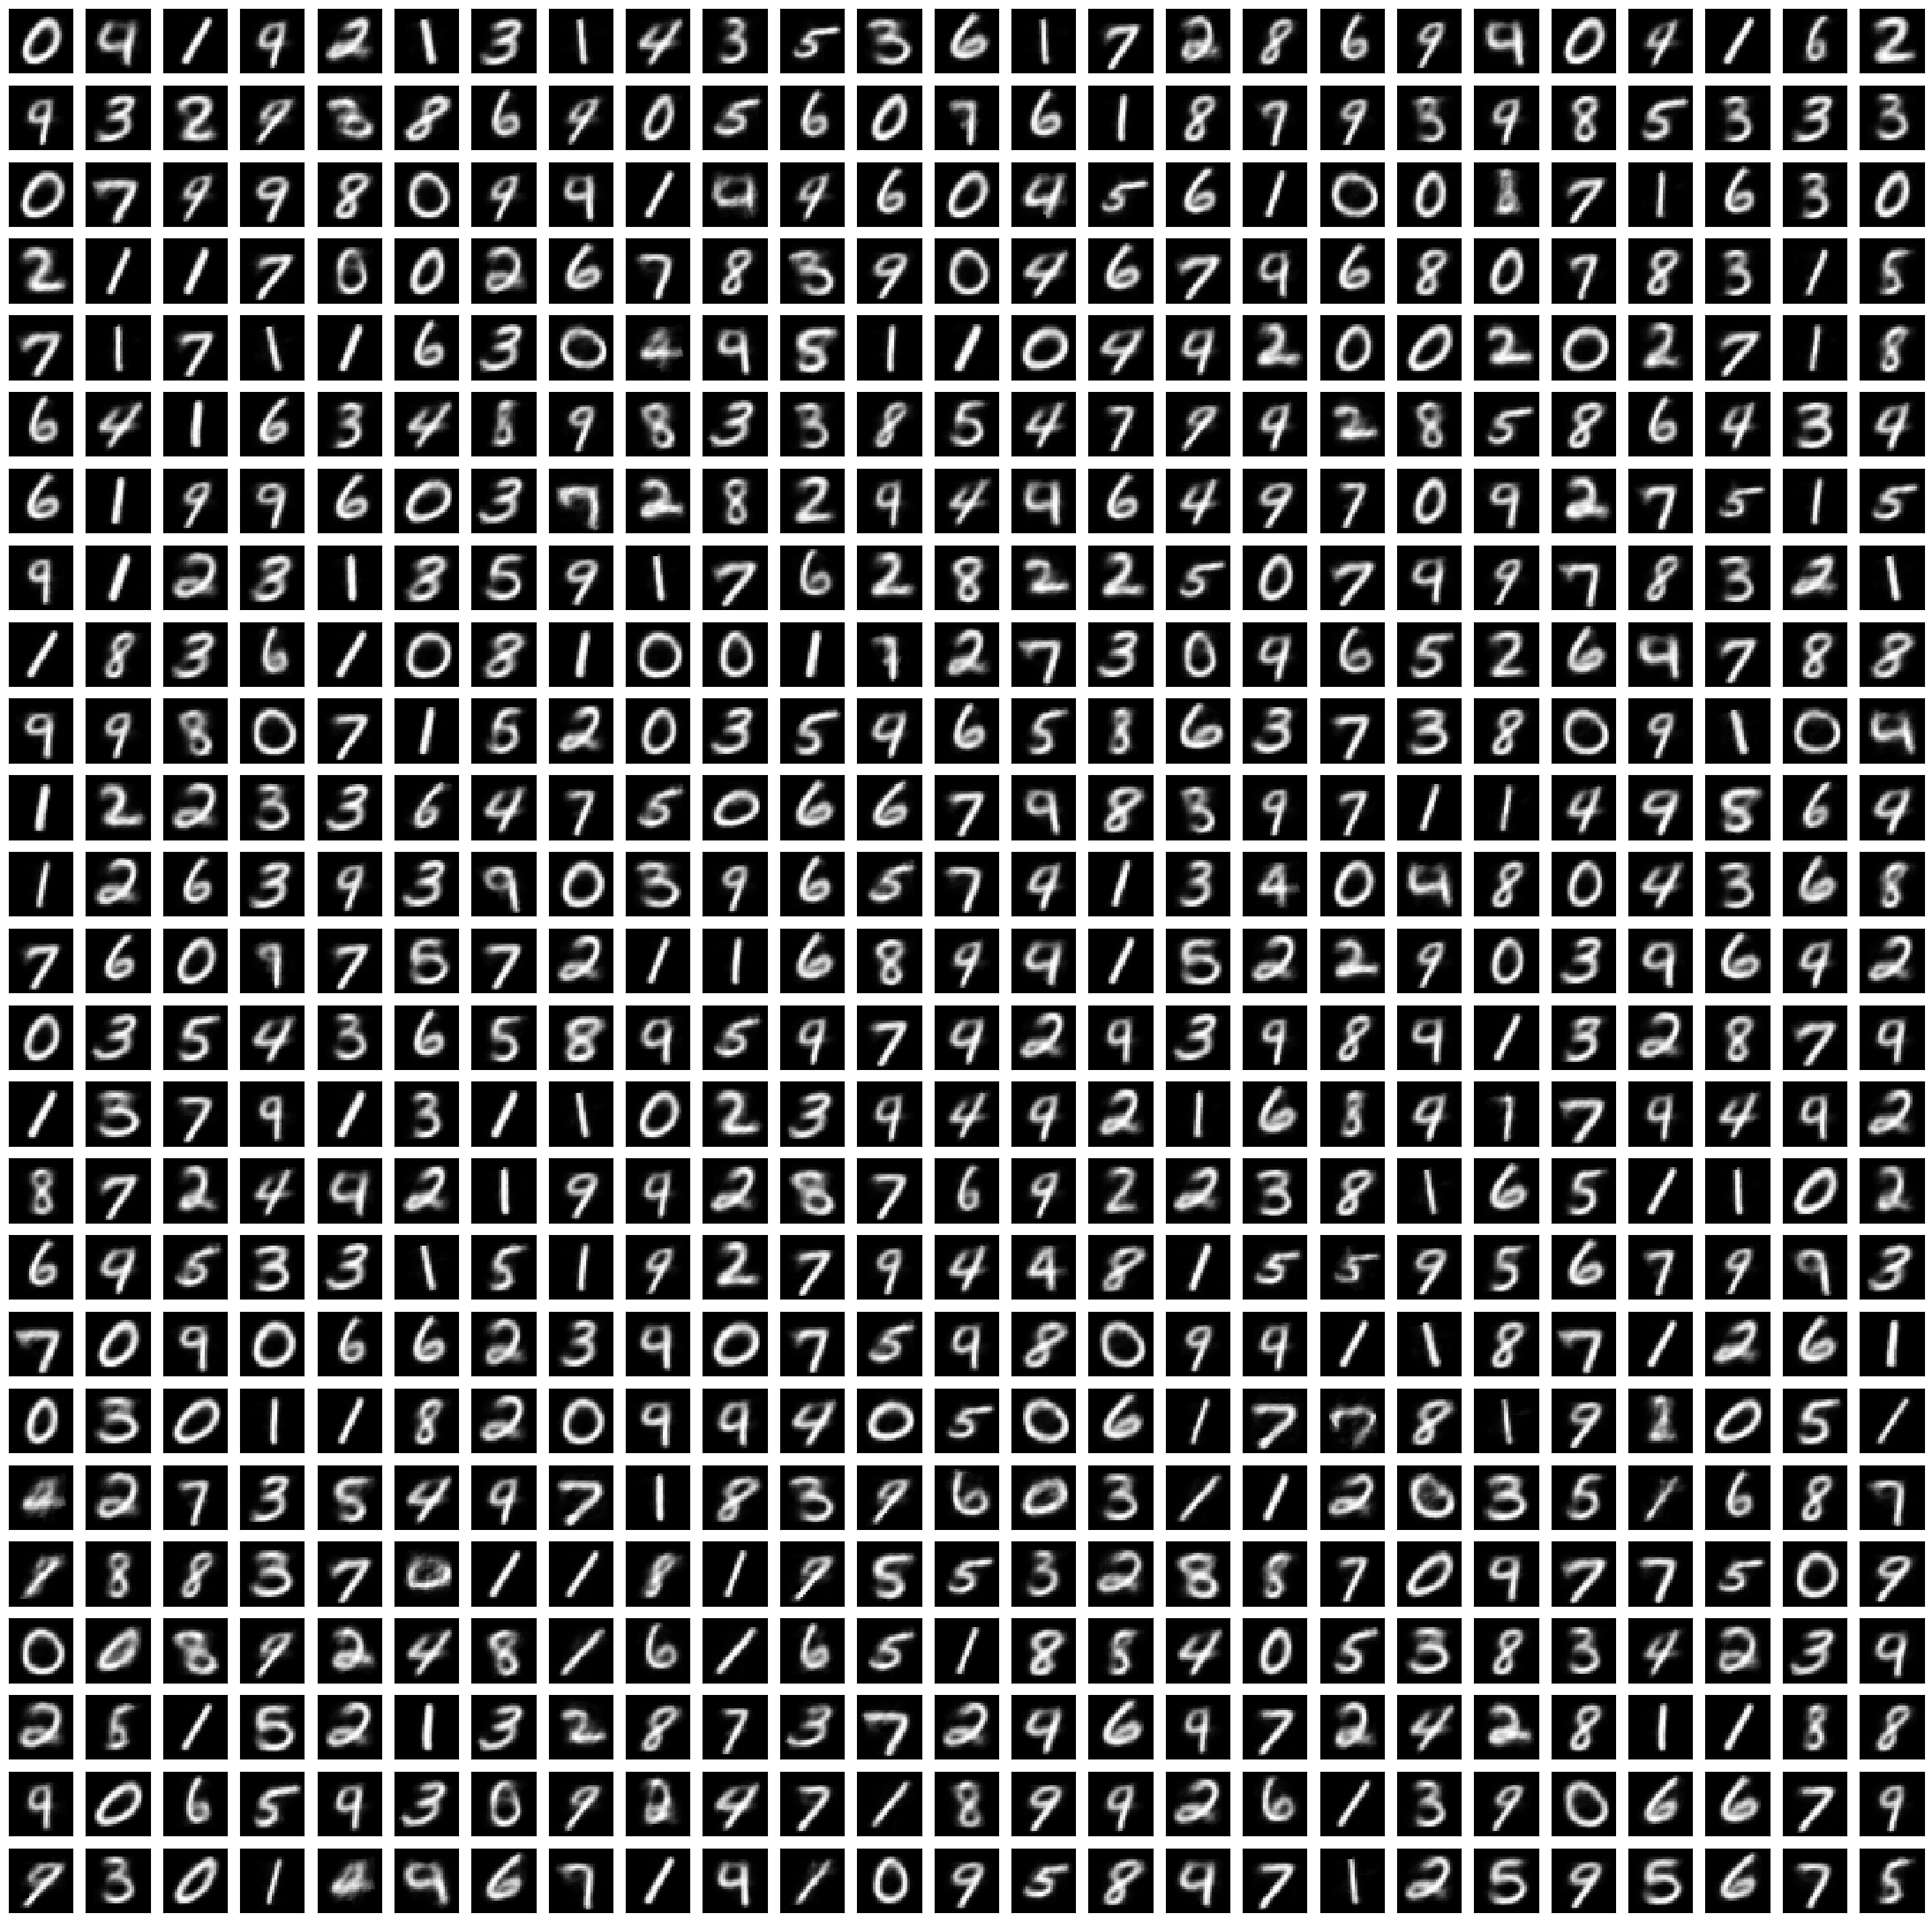

In [11]:
# Visualization of 25 x 25 reconstructed images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(autoencoder.predict(np.expand_dims(x_images[ind].flatten(), 0)).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [12]:
encoder = Model(input_img, encoded)

# Building the decoder
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-4]
encoded_layer_2 = autoencoder.layers[-3]
encoded_layer_3 = autoencoder.layers[-2]
encoded_layer_4 = autoencoder.layers[-1]

decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = encoded_layer_3(decoder)
decoder = encoded_layer_4(decoder)
decoder = Model(encoded_input, decoder)

### Visualizing the images in the manifold

1875/1875 [==============================] - 2s 1ms/step


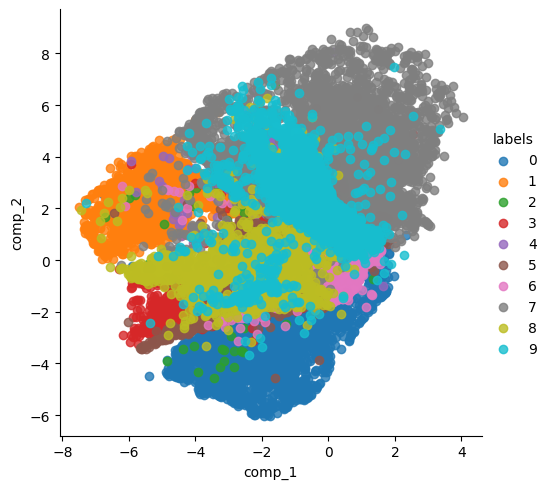

In [13]:
import seaborn as sns

x_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

x_proj = encoder.predict(x_flat[:60000])
x_proj.shape

proj = pd.DataFrame(x_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:60000]
sns.lmplot(x="comp_1",y= "comp_2", hue="labels", data=proj, fit_reg=False)

### Generating new digits by moving along the manifold (latent 2D space)
**Please, adjust the scale whenever necessary.**

### Moving along a circle

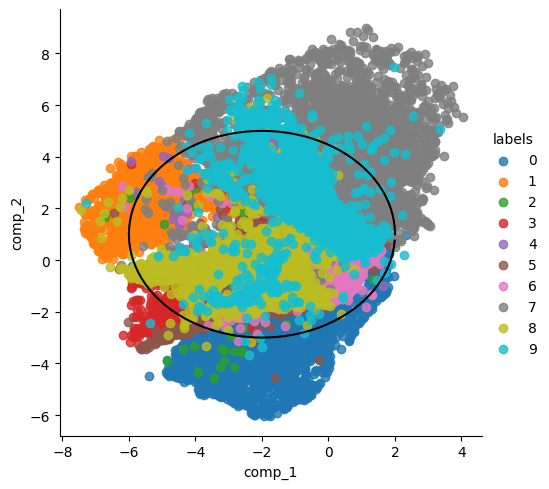

In [31]:
_ = sns.lmplot(x ="comp_1",y= "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [4 * np.cos(2 * np.pi / 100 * i) - 2 for i in range(100)]
all_y = [4 * np.sin(2 * np.pi / 100 * i) + 1 for i in range(100)]
_ = plt.plot(all_x,all_y, color = 'black')

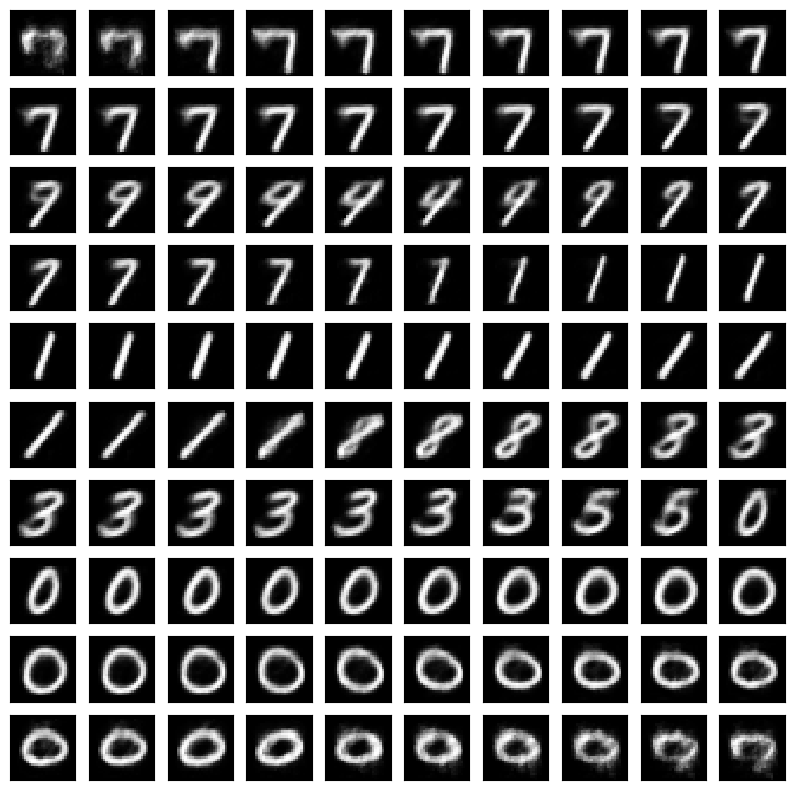

In [32]:
# moving along a circle:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 4 * np.cos(2 * np.pi / 100 * i) - 2
    y = 4 * np.sin(2 * np.pi / 100 * i) + 1
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt, verbose = 0).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### Moving along an ellipse

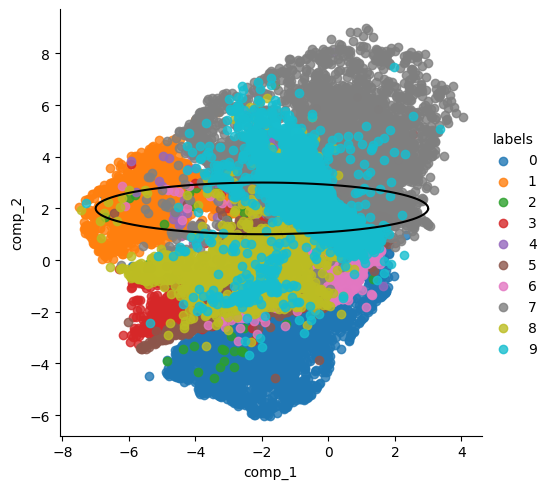

In [34]:
_ = sns.lmplot(x="comp_1", y="comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [5 * np.cos(2 * np.pi / 100 * i) - 2 for i in range(100)]
all_y = [1 * np.sin(2 * np.pi / 100 * i) + 2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

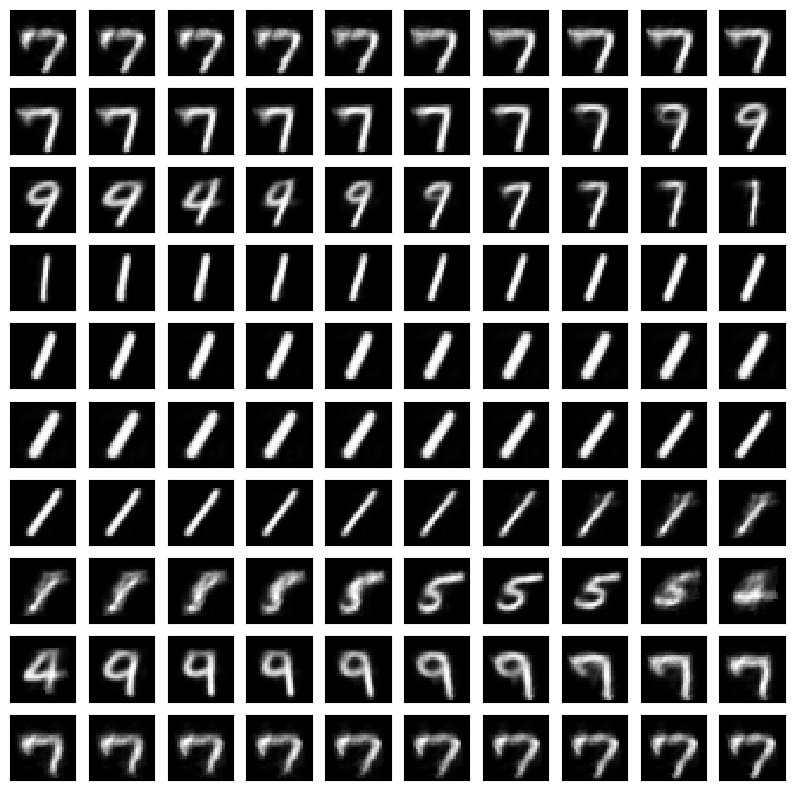

In [35]:
# Moving along an elipse:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 5 * np.cos(2 * np.pi / 100 * i) - 2
    y = 1 * np.sin(2 * np.pi / 100 * i) + 2
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt, verbose = 0).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### Moving along a grid

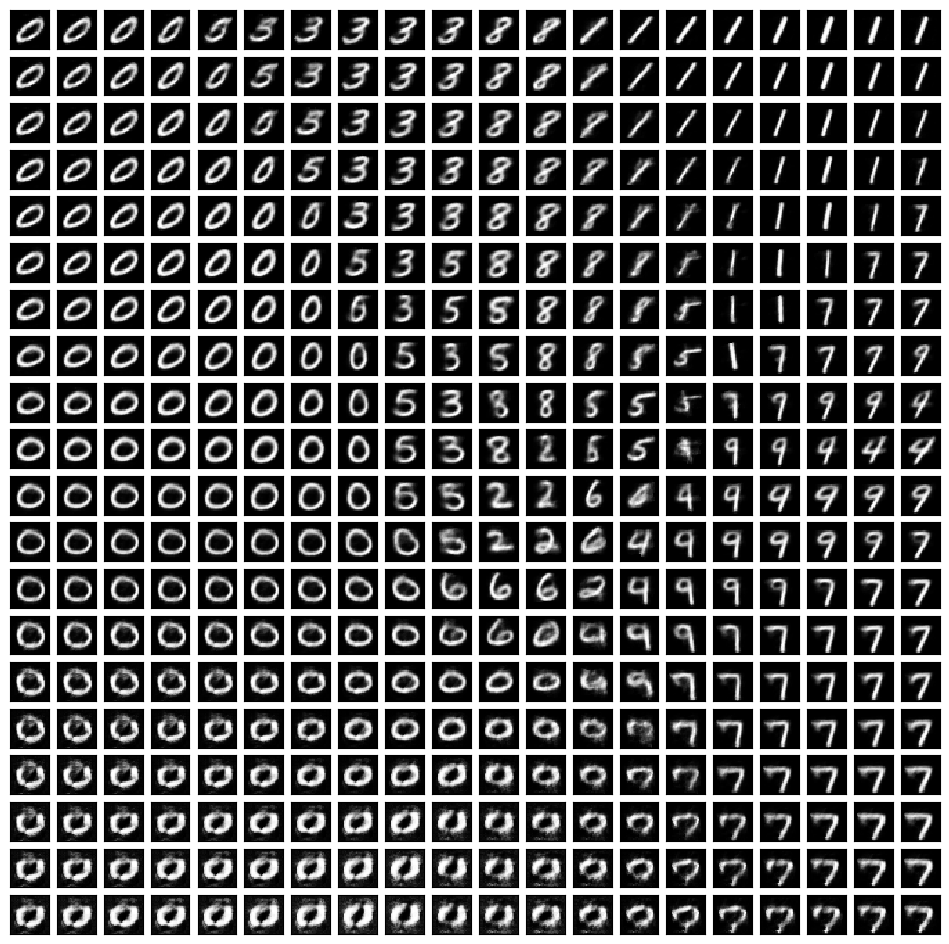

In [36]:
# Moving along a grid:
_ = plt.figure(figsize=(12, 12))

for i in range(20):
    for j in range(20):
        
        _ = plt.subplot(20, 20, i * 20 + j + 1)
        
        pt = np.array([[ -6 + 10 * i / 19, -6 + 10 * j / 19]])
        _ = show(decoder.predict(pt, verbose = 0).reshape((28, 28)))
        _ = plt.xticks([])
        _ = plt.yticks([])